In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:



import zipfile
import os

# Path to the zip file
zip_path = "/content/PlantVillage.zip"
# Directory where files will be extracted
extract_to = "/content/PlantVillage"

# Create a ZipFile object
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extract_to)

print("Files extracted to:", extract_to)




Files extracted to: /content/PlantVillage


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
PlantVillage = "/content/PlantVillage/PlantVillage"


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PlantVillage,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),  # Corrected parameter name and value
    batch_size=BATCH_SIZE,
    # label_mode='int'  # Optional: adjust based on your dataset labels

)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)


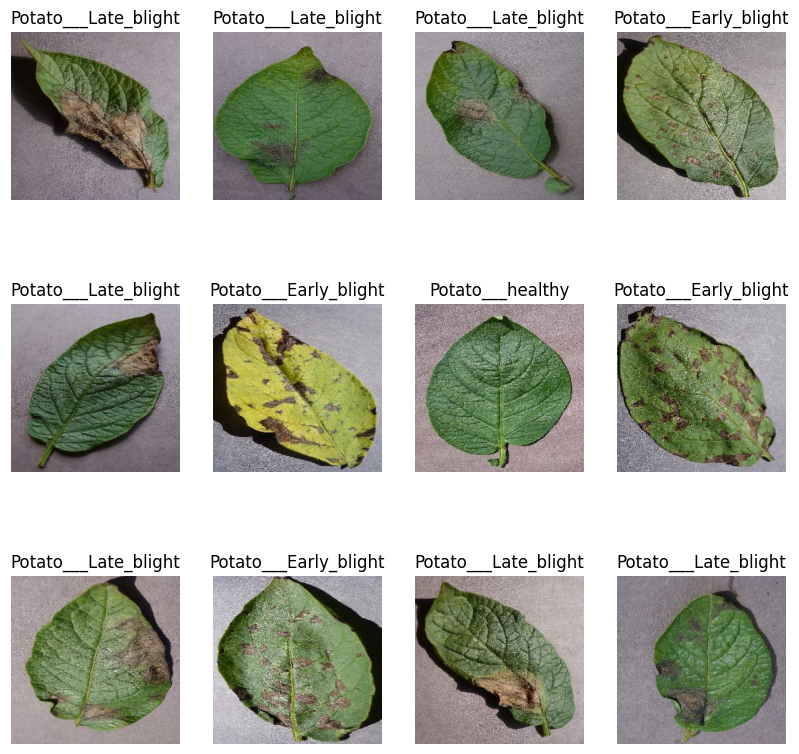

In [ ]:
plt.figure(figsize=(10, 10))

for images_batch,label_batch in dataset.take(1):
  print(images_batch.shape)
  # print(images_batch[0].numpy())
  # print(label_batch.numpy())
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(images_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
    # plt.show()

In [ ]:
len(dataset)

68

In [ ]:
total_data = 100
train_data_percent = 80
validation_data_percent = 10
test_data_percent = 10

training = int(total_data * train_data_percent / 100)
validation = int(total_data * validation_data_percent / 100)
test= total_data - training - validation

print(f"Training data size: {training}")
print(f"Validation data size: {validation}")
print(f"Test data size: {test}")

Training data size: 80
Validation data size: 10
Test data size: 10


splitting the dataset

In [ ]:
train_size = 0.8
len(dataset) * train_size




54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)# get the remaining after subtracting 54
len(test_ds)

14

In [ ]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)


54

In [ ]:
len(val_ds)


6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds =test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255),
])


In [ ]:
data_augmemnation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

cnn

In [ ]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmemnation,
    layers.Conv2D(32,kernel_size = (3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size =(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')


    ])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 sequential_1 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_20 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [ ]:
model.compile (
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(train_ds,epochs=EPOCHS,batch_size = BATCH_SIZE,validation_data=val_ds)


Epoch 1/50
54/54 [==============================] - 15s 97ms/step - loss: 0.8911 - accuracy: 0.5012 - val_loss: 0.8270 - val_accuracy: 0.5312
Epoch 2/50
54/54 [==============================] - 3s 59ms/step - loss: 0.6549 - accuracy: 0.6950 - val_loss: 0.5428 - val_accuracy: 0.7917
Epoch 3/50
54/54 [==============================] - 3s 58ms/step - loss: 0.4698 - accuracy: 0.7922 - val_loss: 0.3304 - val_accuracy: 0.8750
Epoch 4/50
54/54 [==============================] - 3s 60ms/step - loss: 0.2673 - accuracy: 0.9109 - val_loss: 0.2268 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 3s 59ms/step - loss: 0.1476 - accuracy: 0.9416 - val_loss: 0.5153 - val_accuracy: 0.8438
Epoch 6/50
54/54 [==============================] - 3s 61ms/step - loss: 0.2057 - accuracy: 0.9155 - val_loss: 0.2454 - val_accuracy: 0.8958
Epoch 7/50
54/54 [==============================] - 3s 57ms/step - loss: 0.1623 - accuracy: 0.9329 - val_loss: 0.1776 - val_accuracy: 0.9323
Epoch 8/50
5

In [ ]:
scores =model.evaluate(test_ds)

8/8 [==============================] - 0s 27ms/step - loss: 0.0163 - accuracy: 0.9922


In [ ]:
scores

[0.016294701024889946, 0.9921875]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.5011574029922485,
 0.6950231194496155,
 0.7922453880310059,
 0.9108796119689941,
 0.9415509104728699,
 0.9155092835426331,
 0.9328703880310059,
 0.9577546119689941,
 0.9583333134651184,
 0.9675925970077515,
 0.9728009104728699,
 0.9635416865348816,
 0.9612268805503845,
 0.9728009104728699,
 0.9803240895271301,
 0.9728009104728699,
 0.9780092835426331,
 0.9803240895271301,
 0.9809027910232544,
 0.9785879850387573,
 0.9872685074806213,
 0.9901620149612427,
 0.9936342835426331,
 0.9890046119689941,
 0.9253472089767456,
 0.9739583134651184,
 0.9855324029922485,
 0.9855324029922485,
 0.9832175970077515,
 0.9872685074806213,
 0.9814814925193787,
 0.9832175970077515,
 0.9953703880310059,
 0.984375,
 0.9936342835426331,
 0.9895833134651184,
 0.9924768805503845,
 0.9832175970077515,
 0.9959490895271301,
 0.9953703880310059,
 0.984375,
 0.9878472089767456,
 0.9982638955116272,
 0.9982638955116272,
 0.9855324029922485,
 0.9942129850387573,
 0.9942129850387573,
 0.9837962985038757,
 0.984953701

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot train and test

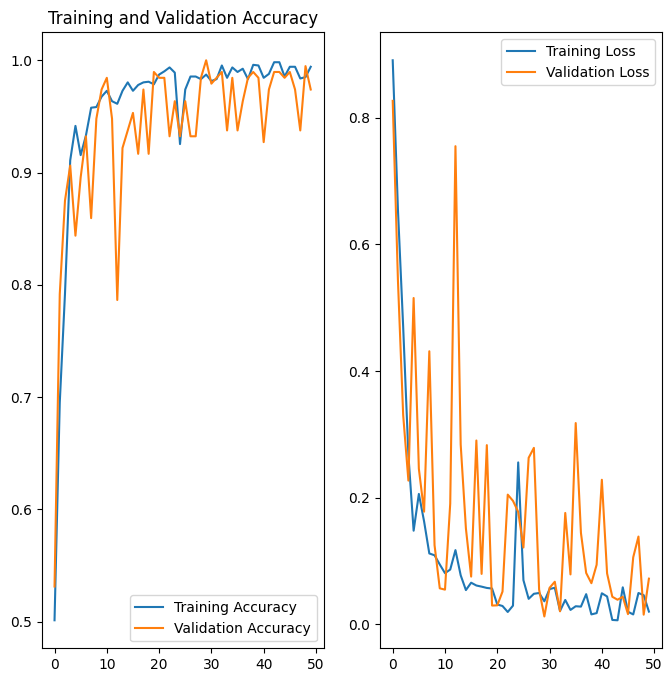

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')

First image to predict
Actual label: Potato___Early_blight
1/1 [==============================] - 0s 40ms/step
predicted label: Potato___Early_blight


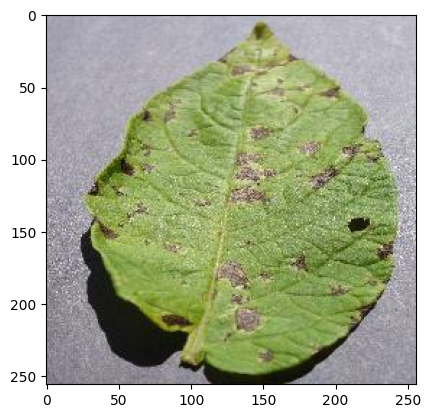

In [ ]:
import numpy as np

for images_batch,labels_batch in test_ds.take(1):#take 1 is for shuffling

 first_image = (images_batch[0].numpy().astype("uint8"))
 first_label = labels_batch[0]


 print("First image to predict")
 plt.imshow(first_image)

 print("Actual label:",class_names[first_label])


batch_prediction = model.predict(images_batch)
print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [ ]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0) #create a batch


  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 18ms/step


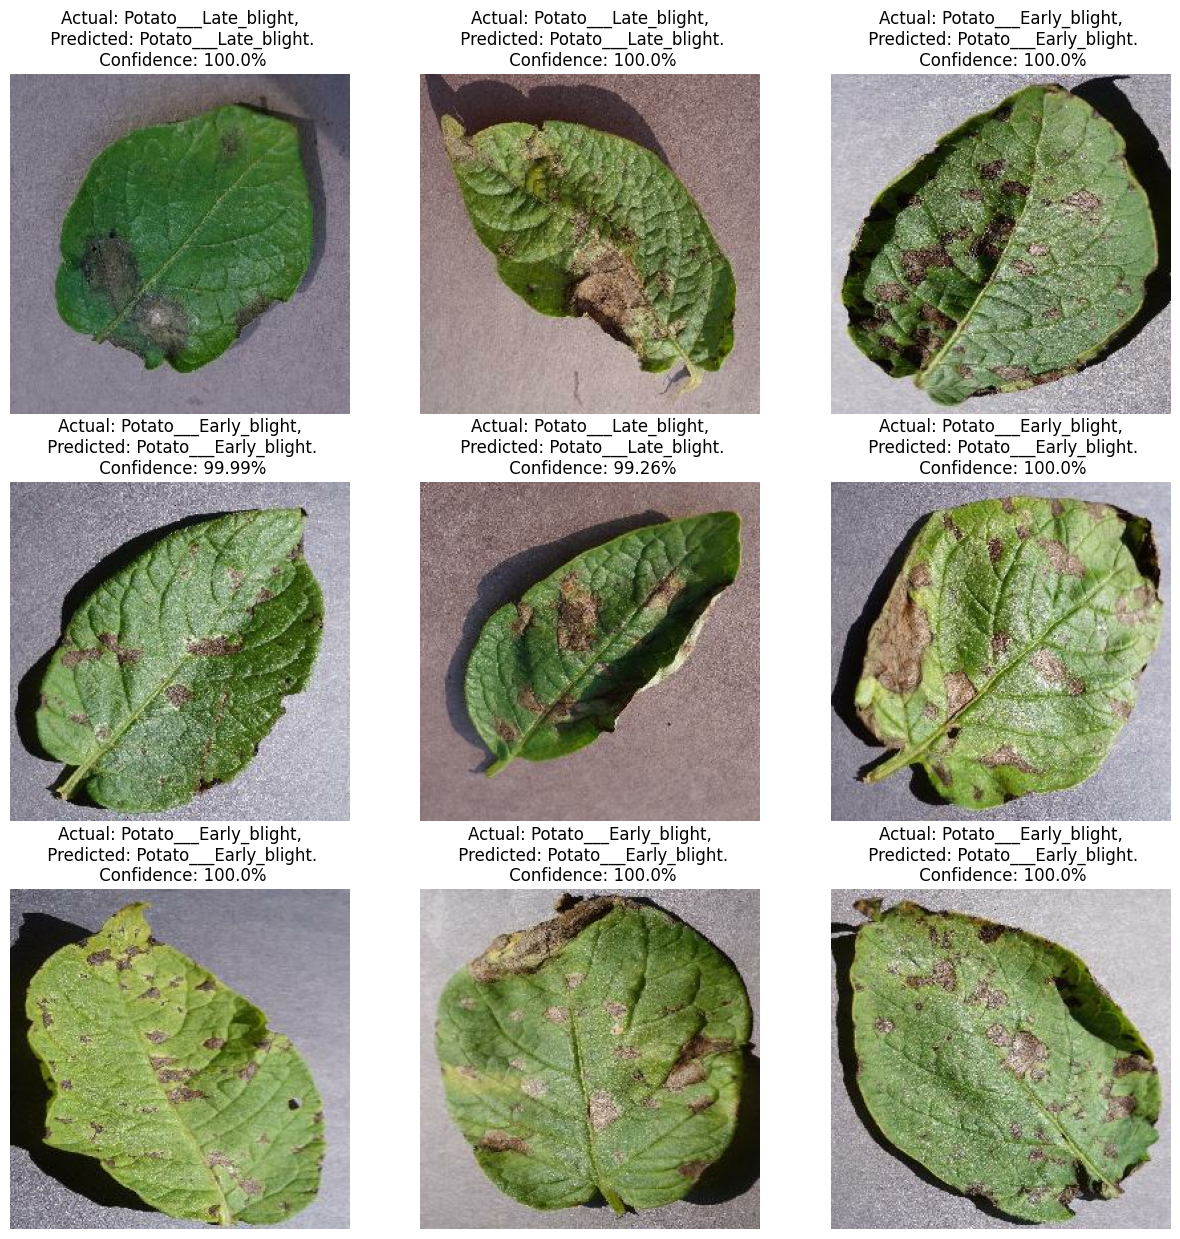

In [ ]:
plt.figure(figsize = (15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1) #sublot
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

    predicted_class,confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")


In [ ]:
import shutil

model_version = 1
model_directory = f"/content/{model_version}"

# Create a zip file from the directory
shutil.make_archive(model_directory, 'zip', model_directory)

# The zip file is now saved as "/content/1.zip"


'/content/1.zip'